# DSCI 619: Deep Learning
## Final Project: Part 2

Symphony Hopkins

##Introduction

We are part of a data scientist team in an AI company. We were given a dataset of restaurant reviews. The dataset is comprised of tab-separated files with two columns:
+ Review: Customers' review
+ Liked : 0 or 1

Our objective is to create Recurrent Neural Network (RNN) models to forecast the **Liked** values based on **Review**, and then determine the most optimal RNN model to recommend to the AI company.

Data Source: [Restaurant Reviews](https://www.kaggle.com/datasets/hj5992/restaurantreviews)

##1.Download the dataset that is about 25 KB from Kaggle into the local disk and unzip it.


We will begin by connect the Google Drive and loading the dataset into the memory.

In [1]:
#connecting to google drive
from google.colab import drive 
drive.mount('/content/gdrive')

#importing libraries
import pandas as pd
import re #regular expression for handling texts very efficiently
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#loading data
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Final Project/Restaurant_Reviews.tsv', delimiter='\t', header=0)
df.head()

Mounted at /content/gdrive


,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


Let's check the shape of the dataframe.

In [ ]:
#checking shape
df.shape

(1000, 2)

We will also check the distribution of Liked values.

In [2]:
#checking distribution of Liked values
print(df['Liked'].value_counts())

1    500
0    500
Name: Liked, dtype: int64


This is a balanced dataset. It's also good practice to check the data types so we will do so.

In [ ]:
#checking data types
df.dtypes

Review    object
Liked      int64
dtype: object

Now we will check for missing values.

In [ ]:
#checking for missing values
df.isnull().sum(axis = 0)

Review    0
Liked     0
dtype: int64

We have no missing values.

##2.Clean and preprocess the text data and split into training and test dataset.


Next, we will clean the Review column using regular expressions. This process will include...
+ Remove all special characters, punctuation and spaces
+ Remove all words with length <=2

In [ ]:
#cleaning the Reviews column using regular expressions
#removing punctuation and spaces; replacing special characters,<br /> in the file
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^A-Za-z0-9]+',' ',x))
df['Review'] = df['Review'].apply(lambda x: re.sub(r"<br />", " ", x))
# removing words with a length less than or equal to 2
df['Review'] = df['Review'].apply(lambda x: re.sub(r'\b[a-zA-Z]{1,2}\b', '', x))

Now, let's check the Reviews column.

In [ ]:
df['Review'].head()

0                                Wow Loved this place 
1                                     Crust  not good 
2            Not tasty and the texture was just nasty 
3    Stopped  during the late May bank holiday off ...
4    The selection  the menu was great and  were th...
Name: Review, dtype: object

Next, we will split the data into training and test data sets. We will perform an 80-20 split.

In [ ]:
#performing train-test split
X = df['Review'].values
y = df['Liked'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

#printing shape
print(f'X_train size={X_train.shape}; X_test size  ={X_test.shape}')

X_train size=(800,); X_test size  =(200,)


Next, we will convert the text to numerical values using TextVectorization.

In [ ]:
#specifying the vocab size
VOCAB_SIZE = 1000
#performing textvectorization
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)

#fitting the state of the preprocessing layer to the dataset.
encoder.adapt(X_train)

##3.Build a baseline RNN model using embedding layer and GRU on the training dataset and evaluate it on the test dataset.


Now, we can build the RNN model using an embedding and GRU layer.

In [ ]:
# specifying dropout rate
dropout_rate = 0.3

#building RNN model
model_1 = tf.keras.Sequential([
    #performing textvectorization which converts the raw texts to indices/integers
    encoder, 
    #embedding layer to convert the indices to numerical vectors
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        #using masking to handle the variable sequence lengths
        mask_zero=True),
    #GRU layer; the default recurrent_activation = sigmoid
    tf.keras.layers.GRU(256, return_sequences=False),
    #classification layer 1
    tf.keras.layers.Dense(128, activation='relu'),
    #dropout layer 1
    tf.keras.layers.Dropout(dropout_rate),
    #classification layer 2
    tf.keras.layers.Dense(64, activation='relu'),
    #classification layer 3; must be equal to 1 since this is the output layer
    tf.keras.layers.Dense(1, activation=None)
])

Let's look at the model summary.




In [ ]:
#summarizing model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 gru (GRU)                   (None, 256)               296448    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

We will implement early stopping. The training will stop if the validation accuracy does not improve for 7 epochs.

In [ ]:
#adding early stopping; if the validation accuracy does not improve for 7 epochs, we will stop training
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 7)

Next, let's configure the model. We will use the **adam** optimizer. We will also use **SparseCategoricalCrossentropy** since the Liked column is encoded as integers (0 = Not Liked, 1 = Liked). Also, since we set the **activation=None**, we have to set **from_logits=True**. We will evaluate the model on it's accuracy.


In [ ]:
#configuring the model; since activation=None we must put from_logits=True
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy']) # we will evaluate the model using acc

Finally, we can train the model.


In [ ]:
%%time
#training the model and storing the history in a variable to plot later
history_1 = model_1.fit(x=X_train, 
                    y=y_train,
                    epochs=100, 
                    validation_data=(X_test,y_test), 
                    callbacks=[callback], 
                    verbose = 1)

Epoch 1/100
25/25 [==============================] - 20s 277ms/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6915 - val_accuracy: 0.5000
Epoch 2/100
25/25 [==============================] - 3s 129ms/step - loss: 0.6912 - accuracy: 0.5000 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 3/100
25/25 [==============================] - 2s 86ms/step - loss: 0.6892 - accuracy: 0.5000 - val_loss: 0.6883 - val_accuracy: 0.5000
Epoch 4/100
25/25 [==============================] - 2s 81ms/step - loss: 0.6847 - accuracy: 0.5000 - val_loss: 0.6846 - val_accuracy: 0.5000
Epoch 5/100
25/25 [==============================] - 2s 82ms/step - loss: 0.6766 - accuracy: 0.5000 - val_loss: 0.6760 - val_accuracy: 0.5000
Epoch 6/100
25/25 [==============================] - 2s 79ms/step - loss: 0.6533 - accuracy: 0.5000 - val_loss: 0.6525 - val_accuracy: 0.5000
Epoch 7/100
25/25 [==============================] - 2s 94ms/step - loss: 0.5797 - accuracy: 0.5275 - val_loss: 0.6013 - val_accuracy: 0.5900
Epo

Let's evaluate the model by visualizing history.

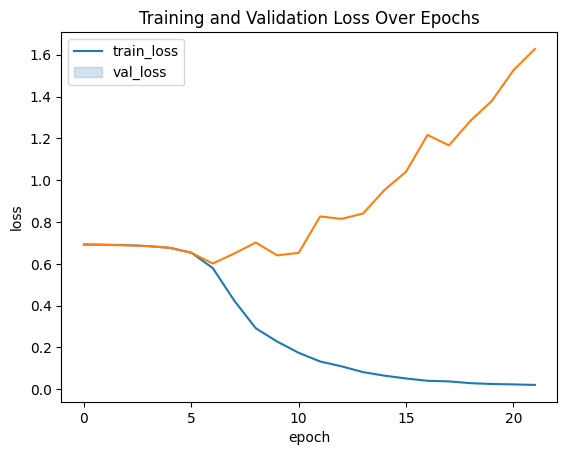

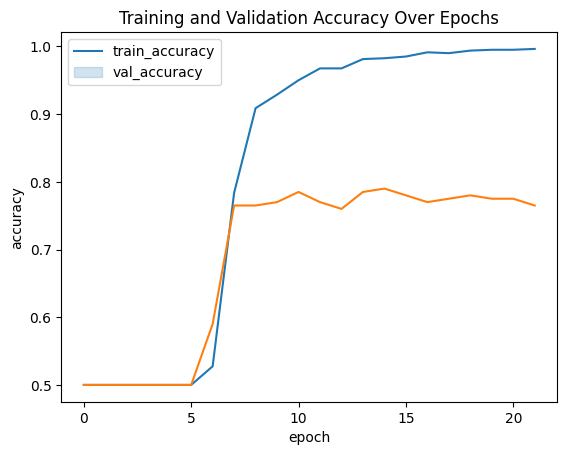

In [ ]:
#visualizing training history
train_history = pd.DataFrame(history_1.history)
train_history['epoch'] = history_1.epoch
#plotting train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
#plotting validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
#adding legends
plt.legend(labels=['train_loss', 'val_loss'])
plt.title('Training and Validation Loss Over Epochs')
plt.show()

#plotting training accuracy
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
#Plot validation accuracy
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
#adding legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])
plt.title('Training and Validation Accuracy Over Epochs')
plt.show()

For the first 5 epochs, the validation loss followed along the same trend as the training loss, but afterwards the validation loss began to increase while the training loss continued to decrease. From the second graph, we can see that the training accuracy was greater than the validation accuracy. All of these characteristics are indications that the model is over-fitting.

Let's also evaluate the model on the test dataset. We will do so by forecasting the **Liked** labels, and then creating a classification report.

In [ ]:
#forecasting the Liked labels
#the cutoff probability is 50%
y_pred = (model_1.predict(X_test)> 0.5).astype(int)

#we need to convert 0 and 1 back to words so that 0 = Not Liked and 1 = Liked for easier readability
#printing a classification report
label_names = ['Not Liked', 'Liked']
report_1 = classification_report(y_test, y_pred, target_names=label_names)
print(report_1)

7/7 [==============================] - 2s 19ms/step
              precision    recall  f1-score   support

   Not Liked       0.74      0.81      0.78       100
       Liked       0.79      0.72      0.75       100

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.76       200
weighted avg       0.77      0.77      0.76       200



The accuracy (=0.77) and F1-score (>=0.75) are okay. There is room for improvement for this model.

##4.Build a second RNN model using embedding layer and LSTM and evaluate it on the test dataset.


Next, we will build a RNN model using an embedding and LSTM layer.

In [ ]:
#building RNN model
model_2 = tf.keras.Sequential([
    #performing textvectorization which converts the raw texts to indices/integers
    encoder, 
    #embedding layer to convert the indices to numerical vectors
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        #using masking to handle the variable sequence lengths
        mask_zero=True),
    #LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    #classification layer 1
    tf.keras.layers.Dense(128, activation='relu'),
    #dropout layer 1
    tf.keras.layers.Dropout(dropout_rate),
    #classification layer 2
    tf.keras.layers.Dense(64, activation='relu'),
    #classification layer 3; must be equal to 1 since this is the output layer
    tf.keras.layers.Dense(1, activation=None)
])

Let's look at the model summary.


In [ ]:
#summarizing model
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 512)              788480    
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)               

Let's configure the model again using the same settings as before.

In [ ]:
#configuring the model; since activation=None we must put from_logits=True
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy']) # we will evaluate the model using accuracy

Now we can train the model.

In [ ]:
%%time
#training the model and storing the history in a variable to plot later
history_2 = model_2.fit(x=X_train, 
                    y=y_train,
                    epochs=100, 
                    validation_data=(X_test,y_test), 
                    callbacks=[callback], 
                    verbose = 1)

Epoch 1/100
25/25 [==============================] - 19s 350ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/100
25/25 [==============================] - 8s 334ms/step - loss: 0.6912 - accuracy: 0.5000 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 3/100
25/25 [==============================] - 9s 364ms/step - loss: 0.6875 - accuracy: 0.5000 - val_loss: 0.6872 - val_accuracy: 0.5000
Epoch 4/100
25/25 [==============================] - 9s 333ms/step - loss: 0.6774 - accuracy: 0.5000 - val_loss: 0.6766 - val_accuracy: 0.5000
Epoch 5/100
25/25 [==============================] - 5s 182ms/step - loss: 0.6481 - accuracy: 0.5038 - val_loss: 0.6461 - val_accuracy: 0.5100
Epoch 6/100
25/25 [==============================] - 6s 256ms/step - loss: 0.5380 - accuracy: 0.6675 - val_loss: 0.7615 - val_accuracy: 0.5750
Epoch 7/100
25/25 [==============================] - 4s 180ms/step - loss: 0.4116 - accuracy: 0.8238 - val_loss: 0.7656 - val_accuracy: 0.695

Let's evaluate the model by visualizing history.

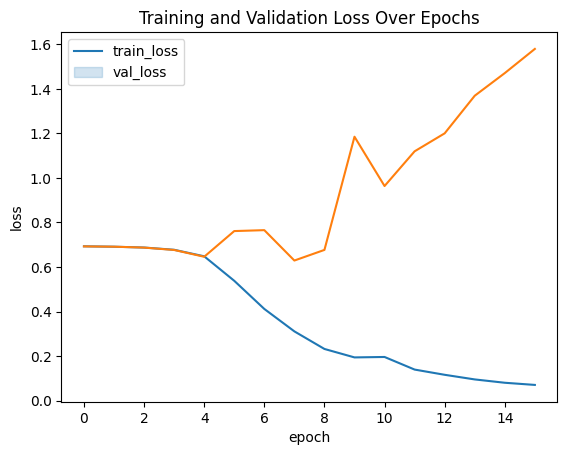

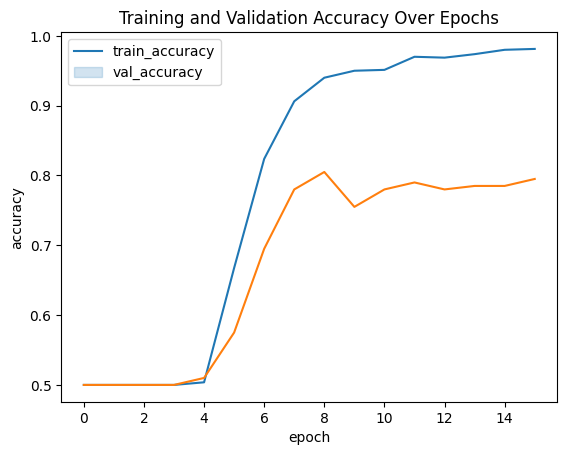

In [ ]:
#visualizing training history
train_history = pd.DataFrame(history_2.history)
train_history['epoch'] = history_2.epoch
#plotting train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
#plotting validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
#adding legends
plt.legend(labels=['train_loss', 'val_loss'])
plt.title('Training and Validation Loss Over Epochs')
plt.show()

#plotting training accuracy
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
#Plot validation accuracy
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
#adding legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])
plt.title('Training and Validation Accuracy Over Epochs')
plt.show()

From the first graph, we can see that as the number of epochs increase the training loss decreases while the validation loss increases. From the second graph, we can see that the training accuracy was greater than the validation accuracy. Both of these findings suggest that the model is over-fitting.

Let's look at the classification report.

In [ ]:
#the cutoff probability is 50%
#forecasting the Recommended IND labels

y_pred = (model_2.predict(X_test)> 0.5).astype(int)

#printing classification report
report_2 = classification_report(y_test, y_pred, target_names=label_names)
print(report_2)

7/7 [==============================] - 3s 41ms/step
              precision    recall  f1-score   support

   Not Liked       0.78      0.82      0.80       100
       Liked       0.81      0.77      0.79       100

    accuracy                           0.80       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.80      0.79       200



The model's accuracy is 0.80, and the F1-scores are approximately the same, making this a decent model. 

##5.Build a third RNN model using embedding layer and GRU and LSTM and evaluate it on the test dataset.


Now, we can build the RNN model using an embedding, GRU, and LSTM layer.

In [ ]:
#building RNN model
model_3 = tf.keras.Sequential([
    #performing textvectorization which converts the raw texts to indices/integers
    encoder, 
    #embedding layer to convert the indices to numerical vectors
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        #using masking to handle the variable sequence lengths
        mask_zero=True),
    #GRU layer; the default recurrent_activation = sigmoid
    tf.keras.layers.GRU(256, return_sequences=True),
    #LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    #classification layer 1
    tf.keras.layers.Dense(128, activation='relu'),
    #dropout layer 1
    tf.keras.layers.Dropout(dropout_rate),
    #classification layer 2
    tf.keras.layers.Dense(64, activation='relu'),
    #classification layer 3; must be equal to 1 since this is the output layer
    tf.keras.layers.Dense(1, activation=None)
])

Let's look at the model summary.

In [ ]:
#summarizing model
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 128)         128000    
                                                                 
 gru_1 (GRU)                 (None, None, 256)         296448    
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)              

Let's configure the model using the same settings as before. 

In [ ]:
#configuring the model; since activation=None we must put from_logits=True
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy']) # we will evaluate the model using accuracy

Finally, let's train the model.

In [ ]:
%%time
#training the model and storing the history in a variable to plot later
history_3 = model_3.fit(x=X_train, 
                    y=y_train,
                    epochs=100, 
                    validation_data=(X_test,y_test),
                    callbacks=[callback], 
                    verbose = 1)

Epoch 1/100
25/25 [==============================] - 28s 570ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 2/100
25/25 [==============================] - 11s 466ms/step - loss: 0.6904 - accuracy: 0.5000 - val_loss: 0.6886 - val_accuracy: 0.5000
Epoch 3/100
25/25 [==============================] - 13s 521ms/step - loss: 0.6806 - accuracy: 0.5000 - val_loss: 0.6725 - val_accuracy: 0.5000
Epoch 4/100
25/25 [==============================] - 8s 303ms/step - loss: 0.6286 - accuracy: 0.5225 - val_loss: 0.6163 - val_accuracy: 0.6550
Epoch 5/100
25/25 [==============================] - 9s 365ms/step - loss: 0.4406 - accuracy: 0.7837 - val_loss: 0.7069 - val_accuracy: 0.7000
Epoch 6/100
25/25 [==============================] - 9s 375ms/step - loss: 0.3125 - accuracy: 0.8913 - val_loss: 0.8079 - val_accuracy: 0.7500
Epoch 7/100
25/25 [==============================] - 8s 302ms/step - loss: 0.2498 - accuracy: 0.9137 - val_loss: 0.9520 - val_accuracy: 0.7

Let's evaluate the model by visualizing history.

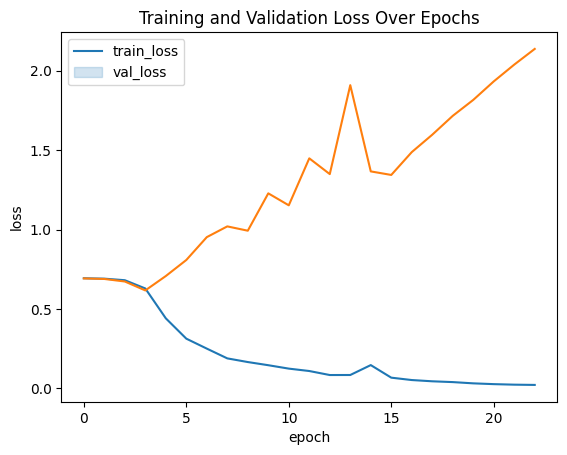

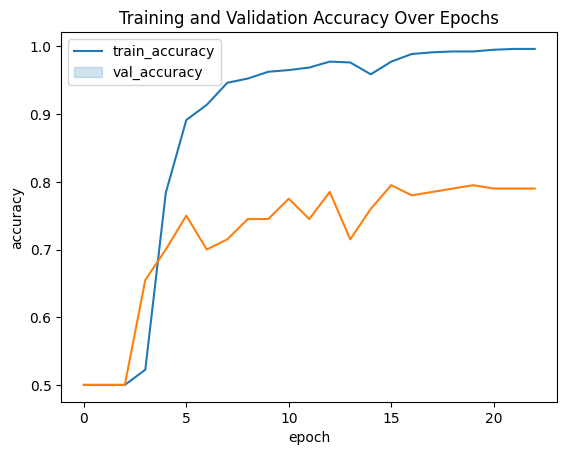

In [ ]:
#visualizing training history
train_history = pd.DataFrame(history_3.history)
train_history['epoch'] = history_3.epoch
#plotting train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
#plotting validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
#adding legends
plt.legend(labels=['train_loss', 'val_loss'])
plt.title('Training and Validation Loss Over Epochs')
plt.show()

#plotting training accuracy
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
#Plot validation accuracy
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
#adding legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])
plt.title('Training and Validation Accuracy Over Epochs')
plt.show()

Similar to the previous graphs, the validation loss is increasing while the training loss is decreasing. We can also see that the training accuracy is higher than the validation accuracy. All of these characteristics are an indication that the model is over-fitting. 

Let's look at the classification report.

In [ ]:
#the cutoff probability is 50%
#forecasting the Liked labels
y_pred = (model_3.predict(X_test)> 0.5).astype(int)

#printing a classification report
report_3 = classification_report(y_test, y_pred, target_names=label_names)
print(report_3)

7/7 [==============================] - 7s 70ms/step
              precision    recall  f1-score   support

   Not Liked       0.78      0.81      0.79       100
       Liked       0.80      0.77      0.79       100

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200



The model's accuracy and f1-scores are 0.79, making this is an okay model.

##6.Which model do you recommend for the model in Q3, Q4, and Q5? Justify your answer.


Because we have a balanced dataset, we evaluated the models based on their accuracies. After evaluating the models on test data, these were the results:
+ Model 1: 0.77
+ Model 2: 0.80
+ Model 3: 0.79

There is room for improvement for all the models. If we address the over-fitting using more regularization methods, we could have a better performing models. All of the models performed approximately the same, but we would recommend Model 2 to the company because it had the highest accuracy. 